In [86]:
import matplotlib.pyplot as plt

# Biosignalsnotebooks python package
import biosignalsnotebooks as bsnb
import numpy as np
# Scientific packages
from numpy import loadtxt, array, mean, logical_and, trapz
from scipy.signal import spectrogram, welch

**SE OBTIENE EL DATASET**




In [87]:
# Carga los datos desde un archivo de texto
data1 = np.loadtxt('1. EEG 30 segundos ojos cerrados.txt')
data2 = np.loadtxt('2. Intervalos 5 segundos.txt')
data3 = np.loadtxt('3. Repeticion paso 1.txt')
data4 = np.loadtxt('4. Ejercicio matematico.txt')
data5 = np.loadtxt('5. Flash.txt')


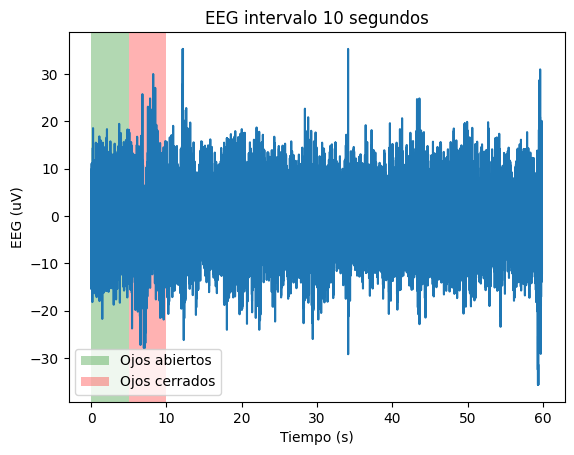

In [88]:

# Usa solo la sexta columna de datos
eeg2 = data2[:,5]

resolution = 10
device = "bitalino_rev"
sr = 1000

#Unit Conversion
signal_uv = bsnb.raw_to_phy("EEG", "biosignalsplux", eeg2, resolution, "uV")
time_uv = bsnb.generate_time(signal_uv, sr)
# Crea una nueva figura
plt.figure()

# Crea un gráfico de línea para el canal seleccionado
plt.plot(time_uv, signal_uv)
plt.xlabel('Tiempo (s)')
plt.ylabel('EEG (uV)')
plt.title('EEG intervalo 10 segundos')

# Agrega una leyenda
plt.legend(['EEG'])

# Resalta el tramo con los ojos abiertos
plt.axvspan(time_uv[0], time_uv[5*1000], facecolor='green', alpha=0.3, label='Ojos abiertos')

# Resalta el tramo con los ojos cerrados
plt.axvspan(time_uv[5*1000], time_uv[1000*10], facecolor='red', alpha=0.3, label='Ojos cerrados')

# Muestra la leyenda
plt.legend()

# Muestra el gráfico
plt.show()

# Cierra la figura actual
plt.close()


**PROCESAMIENTO BSNBSIGNALS**

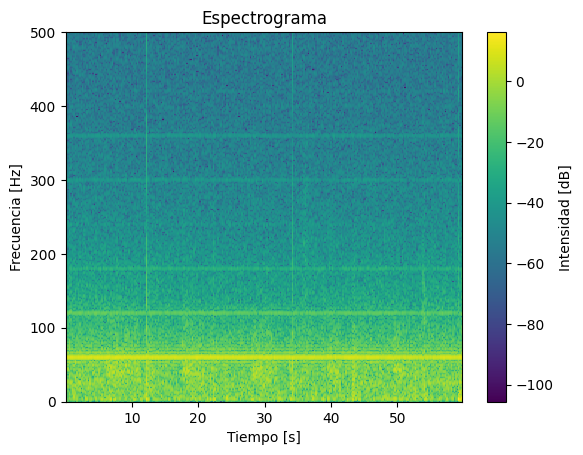

In [89]:
#Spectrogram function, using scipy.signal.spectrogram
f, t, Sxx = spectrogram(signal_uv, fs = sr, nfft = 2000)

# Plot spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Convierte la amplitud a escala logarítmica en decibeles
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Intensidad [dB]')
plt.title('Espectrograma')
plt.show()

**Filtering of the EEG data with a Baseline Shift and a Bandpass Filter**

In [90]:

# Time window of closed eyes
t_closed_start = 5 # lower limit of time window (s)
sample_closed_start = t_closed_start*sr

t_closed_end = 10 # Upper limit of time window (s)
sample_closed_end = t_closed_end*sr

# Cuttoff frequencies
f1 = 3 # lower cutoff frequency for bandpass filter (Hz)
f2 = 30 # Upper cutoff frequency for bandpass filter (Hz)

# Baseline shift of window
signal_shift_window_eyes_closed = array(signal_uv[sample_closed_start:sample_closed_end]) - mean(array(signal_uv[sample_closed_start:sample_closed_end]))

# Digital Bandpass filtering with cutoff frequencies of f1=3 and f2=30 Hz using bsns.bandpass
filtered_signal_closed_eyes = bsnb.bandpass(signal_shift_window_eyes_closed, f1, f2, order = 2, fs = sr)

# Time window of opened eyes
t_opened_start = 0 # lower limit of time window (s)
sample_opened_start = t_opened_start*sr

t_opened_end = 5 # Upper limit of time window (s)
sample_opened_end = t_opened_end*sr

#Baseline shift of window
signal_shift_window_eyes_opened = array(signal_uv[sample_opened_start:sample_opened_end])-mean(array(signal_uv[sample_opened_start:sample_opened_end]))

#Digital Bandpass filtering with cutoff frequencies of f1=3 and f2=30 Hz using bsns.bandpass
filtered_signal_opened_eyes = bsnb.bandpass(signal_shift_window_eyes_opened, f1, f2, order = 2, fs = sr)


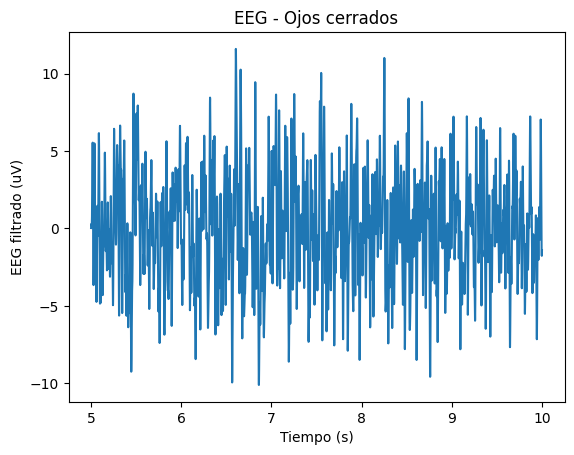

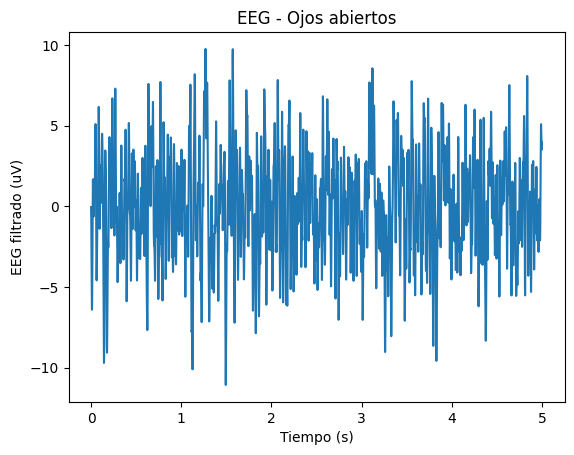

In [91]:
# Graficar señal de ojos cerrados
plt.figure()
plt.plot(np.arange(t_closed_start, t_closed_end, 1/sr), filtered_signal_closed_eyes)
plt.xlabel('Tiempo (s)')
plt.ylabel('EEG filtrado (uV)')
plt.title('EEG - Ojos cerrados')
plt.show()

# Graficar señal de ojos abiertos
plt.figure()
plt.plot(np.arange(t_opened_start, t_opened_end, 1/sr), filtered_signal_opened_eyes)
plt.xlabel('Tiempo (s)')
plt.ylabel('EEG filtrado (uV)')
plt.title('EEG - Ojos abiertos')
plt.show()

**Generation of Power Spectrum by Fast Fourier Transform (FFT) and Welchs Method**

In [92]:

#Time Windows for Welchs method 
win = 5 * sr # 5 seconds time windows.

#FFT with time windows using scipy.signal.welch
freq_axis_eyes_closed, power_spect_eyes_closed = welch(filtered_signal_closed_eyes, sr, nperseg=win)

#FFT with time windows using scipy.signal.welch for open eyes time window
freq_axis_eyes_opened, power_spect_eyes_opened = welch(filtered_signal_opened_eyes, sr, nperseg=win)

#Define Frequency Band limits:
freq_low = 8 #lower limit for alpha band
freq_high = 12 #Upper limit for alpha band 

#Find the intersection Values of the alpha band in the frequency vector [Eyes Closed]
idx_alpha_eyes_closed = logical_and(freq_axis_eyes_closed >= freq_low, freq_axis_eyes_closed <= freq_high)

#Find the intersection Values of the alpha band in the frequency vector [Eyes Opened]
idx_alpha_eyes_opened = logical_and(freq_axis_eyes_opened >= freq_low, freq_axis_eyes_opened <= freq_high)

#Frequency Resolution
freq_res_closed_eyes = freq_axis_eyes_closed[1] - freq_axis_eyes_closed[0] 

#Compute the Absolute Power with numpy.trapz:
alpha_power_closed_eyes = trapz(power_spect_eyes_closed[idx_alpha_eyes_closed],dx=freq_res_closed_eyes)

#Frequency Resolution
freq_res_opened_eyes = freq_axis_eyes_opened[1] - freq_axis_eyes_opened[0] 

#Compute the Absolute Power with numpy.trapz:
alpha_power_opened_eyes = trapz(power_spect_eyes_opened[idx_alpha_eyes_opened],dx=freq_res_opened_eyes)


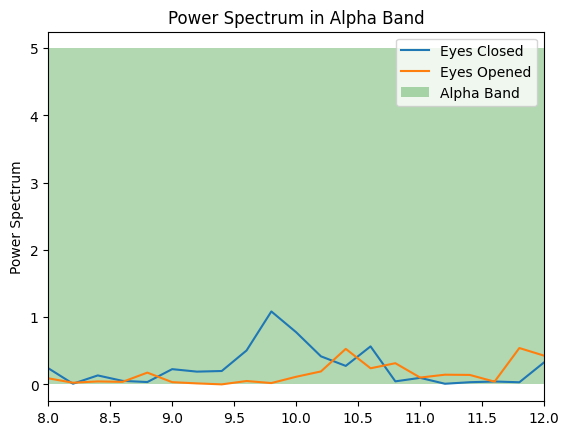

Alpha Power (Eyes Closed): 1.006961352295883
Alpha Power (Eyes Opened): 0.6080360460562677


In [93]:

# Create a new figure
plt.figure()

# Plot power spectrum for eyes closed
plt.plot(freq_axis_eyes_closed, power_spect_eyes_closed, label='Eyes Closed')

# Plot power spectrum for eyes opened
plt.plot(freq_axis_eyes_opened, power_spect_eyes_opened, label='Eyes Opened')

# Highlight the alpha band in the plot
plt.fill_between(freq_axis_eyes_closed, 0, np.max(power_spect_eyes_closed), where=idx_alpha_eyes_closed, facecolor='green', alpha=0.3, label='Alpha Band')

# Set x-axis limits to focus on the alpha band
plt.xlim(freq_low, freq_high)

# Set y-axis label
plt.ylabel('Power Spectrum')

# Set title
plt.title('Power Spectrum in Alpha Band')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Close the current figure
plt.close()

# Print the absolute power in the alpha band for eyes closed and eyes opened
print("Alpha Power (Eyes Closed):", alpha_power_closed_eyes)
print("Alpha Power (Eyes Opened):", alpha_power_opened_eyes)

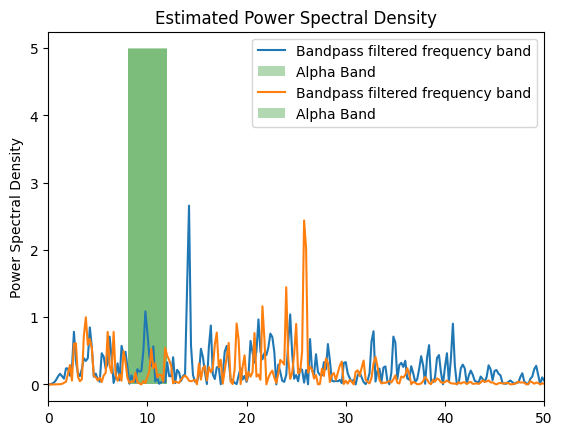

Alpha Power (Eyes Closed): 1.006961352295883
Alpha Power (Eyes Opened): 0.6080360460562677


In [94]:

# Create a new figure
plt.figure()

# Plot power spectrum for eyes closed
plt.plot(freq_axis_eyes_closed, power_spect_eyes_closed, label='Bandpass filtered frequency band')

# Highlight the alpha band in the plot for eyes closed
plt.fill_between(freq_axis_eyes_closed, 0, np.max(power_spect_eyes_closed), where=idx_alpha_eyes_closed, facecolor='green', alpha=0.3, label='Alpha Band')

# Plot power spectrum for eyes opened
plt.plot(freq_axis_eyes_opened, power_spect_eyes_opened, label='Bandpass filtered frequency band')

# Highlight the alpha band in the plot for eyes opened
plt.fill_between(freq_axis_eyes_opened, 0, np.max(power_spect_eyes_opened), where=idx_alpha_eyes_opened, facecolor='green', alpha=0.3, label='Alpha Band')

# Set x-axis limits
plt.xlim(0, 50)

# Set y-axis label
plt.ylabel('Power Spectral Density')

# Set title
plt.title('Estimated Power Spectral Density')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Close the current figure
plt.close()

# Print the absolute power in the alpha band for eyes closed and eyes opened
print("Alpha Power (Eyes Closed):", alpha_power_closed_eyes)
print("Alpha Power (Eyes Opened):", alpha_power_opened_eyes)

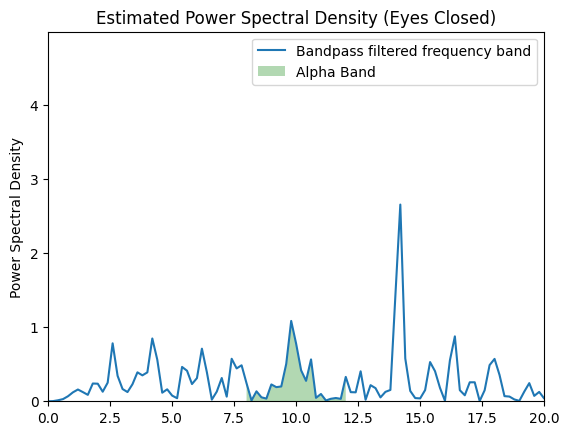

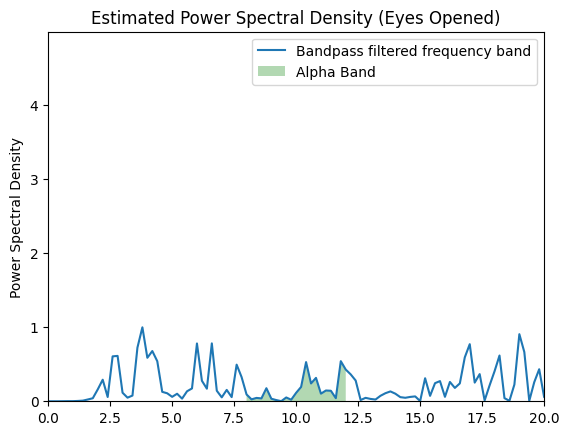

In [95]:
# Plot para ojos cerrados
plt.figure()
plt.plot(freq_axis_eyes_closed, power_spect_eyes_closed, label='Bandpass filtered frequency band')
plt.fill_between(freq_axis_eyes_closed, 0, power_spect_eyes_closed, where=(freq_axis_eyes_closed >= freq_low) & (freq_axis_eyes_closed <= freq_high) & (power_spect_eyes_closed <= power_spect_eyes_closed.max()), facecolor='green', alpha=0.3, label='Alpha Band')
plt.xlim(0, 20)
plt.ylim(0, power_spect_eyes_closed.max())
plt.ylabel('Power Spectral Density')
plt.title('Estimated Power Spectral Density (Eyes Closed)')
plt.legend()
plt.show()
plt.close()

# Plot para ojos abiertos
plt.figure()
plt.plot(freq_axis_eyes_opened, power_spect_eyes_opened, label='Bandpass filtered frequency band')
plt.fill_between(freq_axis_eyes_opened, 0, power_spect_eyes_opened, where=(freq_axis_eyes_opened >= freq_low) & (freq_axis_eyes_opened <= freq_high) & (power_spect_eyes_opened <= power_spect_eyes_opened.max()), facecolor='green', alpha=0.3, label='Alpha Band')
plt.xlim(0, 20)
plt.ylim(0, power_spect_eyes_opened.max())
plt.ylabel('Power Spectral Density')
plt.title('Estimated Power Spectral Density (Eyes Opened)')
plt.legend()
plt.show()
plt.close()